In [1]:
import numpy as np
import pandas as pd
import netCDF4 as nc
import geopandas as gpd
from netCDF4 import num2date
import datetime

from tqdm import tqdm

tqdm.pandas()
from shapely.geometry import Point

import matplotlib.pyplot as plt

import platform

from cartopy import crs as ccrs

if platform.system() == 'Darwin':
    plt.rcParams["font.family"] = 'Arial Unicode MS'
elif platform.system() == 'Windows':
    plt.rcParams["font.family"] = 'SimHei'
else:
    pass

In [ ]:
# based on netCDF4 data
nc_data = nc.Dataset("./data/nc/rhum.day.ltm.nc")

### Time slice

In [41]:

time_var = nc_data.variables['time']
time_units = time_var.units
raw_time_data = np.array(time_var)
raw_data = np.array(nc_data.variables['rhum'])

In [ ]:
# def cftime2datetime(cftime, units, format='%Y-%m-%d %H:%M:%S'):
#     """
#     将nc文件里面的时间格式 从cftime 转换到 datetime格式
#     :param cftime:
#     :param units:
#     :param format:
#     :return:
#     """
#     return datetime.datetime.strptime(num2date(times=cftime, units=units).strftime(format), format)


# clean_time_data = pd.Series([cftime2datetime(i, units=time_units) for i in raw_time_data])
# clean_time_data[:4]

0    0001-01-01 00:00:00
1    0001-01-02 00:00:00
2    0001-01-03 00:00:00
3    0001-01-04 00:00:00
dtype: object

In [ ]:


def cftime2datetime(cftime_time, units):
    """
    将 nc 文件的 cftime 时间转换为标准的 datetime 时间格式
    :param cftime_time: cftime 对象或数值时间
    :param units: 时间单位，如 'days since 1900-1-1'
    :return: datetime.datetime 对象
    """
    dt = num2date(cftime_time, units=units)  
    if isinstance(dt, datetime.datetime):  # if dt is already a datetime object, return it directly
        return dt
    else:
        return datetime.datetime(dt.year, dt.month, dt.day, dt.hour, dt.minute, dt.second)  # convert cftime object to datetime object 


clean_time_data = pd.Series([cftime2datetime(i, units=time_units) for i in raw_time_data]) 


print(clean_time_data[:4])


0    0001-01-01 00:00:00
1    0001-01-02 00:00:00
2    0001-01-03 00:00:00
3    0001-01-04 00:00:00
dtype: object


In [ ]:
# replace the nonsensical year with a valid year in datetime range
clean_time_data = clean_time_data.apply(lambda x: x.replace(year=1991))

raw_data[(1 <= clean_time_data.dt.month) & (clean_time_data.dt.month <= 3), :, :].shape


(90, 8, 73, 144)

In [46]:
clean_time_data>='1991-11-01'

0      False
1      False
2      False
3      False
4      False
       ...  
360     True
361     True
362     True
363     True
364     True
Length: 365, dtype: bool

### Crop

In [56]:
raw_lat_data = np.array(nc_data.variables['lat'])
raw_lon_data = np.array(nc_data.variables['lon'])
missing_value = nc_data.variables['rhum'].missing_value

In [ ]:
boundary = gpd.read_file(filename="./data/json/boundary202111.json")
# avoid modifying the original data
boundary_data = boundary.copy()  
boundary_data['geometry'] = boundary_data.buffer(0)


Skipping field center: unsupported OGR type: 3
Skipping field centroid: unsupported OGR type: 3


In [51]:
def pic(lon, lat) -> bool:
    """
    检测一个点是否在中国边界线内
    lon:东经
    lat:北纬
    :param lon:
    :param lat:
    :return:
    """
    return boundary_data.contains(Point(lon, lat))[0]

In [ ]:
# also need to check the crs of the raw data
# 经纬度数据（如经度和纬度）通常与地理坐标系（如 WGS84）相关。
raw_lon_data, raw_lat_data

(array([  0. ,   2.5,   5. ,   7.5,  10. ,  12.5,  15. ,  17.5,  20. ,
         22.5,  25. ,  27.5,  30. ,  32.5,  35. ,  37.5,  40. ,  42.5,
         45. ,  47.5,  50. ,  52.5,  55. ,  57.5,  60. ,  62.5,  65. ,
         67.5,  70. ,  72.5,  75. ,  77.5,  80. ,  82.5,  85. ,  87.5,
         90. ,  92.5,  95. ,  97.5, 100. , 102.5, 105. , 107.5, 110. ,
        112.5, 115. , 117.5, 120. , 122.5, 125. , 127.5, 130. , 132.5,
        135. , 137.5, 140. , 142.5, 145. , 147.5, 150. , 152.5, 155. ,
        157.5, 160. , 162.5, 165. , 167.5, 170. , 172.5, 175. , 177.5,
        180. , 182.5, 185. , 187.5, 190. , 192.5, 195. , 197.5, 200. ,
        202.5, 205. , 207.5, 210. , 212.5, 215. , 217.5, 220. , 222.5,
        225. , 227.5, 230. , 232.5, 235. , 237.5, 240. , 242.5, 245. ,
        247.5, 250. , 252.5, 255. , 257.5, 260. , 262.5, 265. , 267.5,
        270. , 272.5, 275. , 277.5, 280. , 282.5, 285. , 287.5, 290. ,
        292.5, 295. , 297.5, 300. , 302.5, 305. , 307.5, 310. , 312.5,
      

In [ ]:
slice_level = 1
slice_day = '1991-09-01'
single_data = raw_data[(clean_time_data == slice_day), slice_level,:, :].copy().squeeze()
# single_data = raw_data[1,1,:,:].copy()
single_data[single_data == missing_value] = np.nan

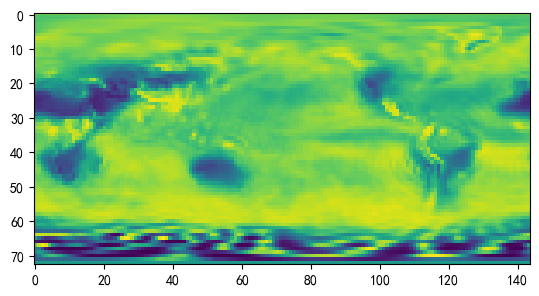

In [104]:
fig, ax = plt.subplots()
ax.imshow(single_data)

In [ ]:
# 原始数据是一个网格数据
# 2.5 degree x 2.5 degree global grids (144x73)
# 0.0E to 357.5E, 90.0N to 90.0S
mask_matrix = np.full(shape=single_data.shape, fill_value=False)

mask_matrix.shape

(73, 144)

In [ ]:
# 通过判断每个点是否在中国边界内，生成一个掩码矩阵 
lon_grid, lat_grid = np.meshgrid(raw_lon_data, raw_lat_data)

lon_flat = lon_grid.flatten()
lat_flat = lat_grid.flatten()

# 利用 Pandas 将数据转为 DataFrame 进行矢量化处理
df = pd.DataFrame({'lon': lon_flat, 'lat': lat_flat})

mask_values = df.apply(lambda row: pic(row['lon'], row['lat']), axis=1).values

mask_matrix = mask_values.reshape(lon_grid.shape)

In [108]:
single_data[~mask_matrix] = np.nan

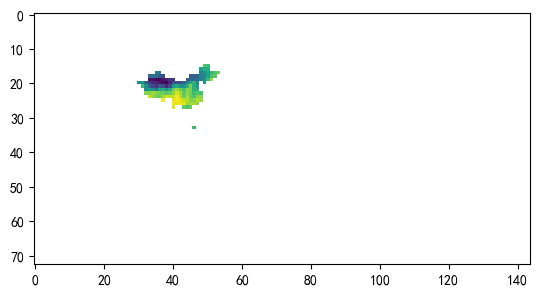

In [109]:
fig, ax = plt.subplots()
ax.imshow(single_data)

In [ ]:
import rasterio
def array2gtiff(array, filename):
    """
    将一个矩阵保存为tiff文件,
    这里还可以设置tiff的crs和transofrm。更多，可以查看rasterio的官网或者下面的这个链接
    https://gis.stackexchange.com/questions/279953/numpy-array-to-gtiff-using-rasterio-without-source-raster
    :param array: shape:(row, col)
    :param filename:
    :return:
    """
    with rasterio.open(filename, 'w', driver='GTiff',
                       height=array.shape[0], width=array.shape[1],
                       count=1, dtype=str(array.dtype), 
                       crs=boundary_data.crs) as f:
        f.write(array, 1)

# test function
array2gtiff(array=single_data, filename="结果/testchina.tiff")